# TP: Cuidado! Lluvia de Hamburguesas - Parte 1

## Grupo 4
Integrantes:
- Flouret, Agustín Miguel
- Milhas, Facundo

In [57]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from collections import Counter
import requests

**Introducción**

En este trabajo se analizarán varios datos recolectados, de una serie de atributos climáticos por día en distintos barrios y del comportamiento de una máquina que hace llover hamburguesas, con el objetivo de determinar si la misma se activará al día siguiente o no.

Tenemos como objetivo interpretear los datos, visualizandolos, y encontrar relaciones entre los mismos, logrando asi determinar patrones entre ellos, con la finalidad de utilizar lo aprendido para realizar un baseline.

Leemos los archivos de los datasets al data frame:

In [2]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv") as r, open("features.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

with requests.get(
    "https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv") as r, open("target.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

In [58]:
df_features = pd.read_csv("features.csv")

/usr/local/Cellar/jupyterlab/3.1.9/libexec/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [59]:
df_target = pd.read_csv("target.csv")

Unimos la tabla donde se encuentra nuestro valor target (la variable booleana que indica si llovieron o no hamburguesas al dia siguiente) con la tabla de features, todo en un mismo Data Frame, a través del id.

In [60]:
df = df_features.merge(df_target, left_on='id', right_on='id')

Imprimimos las primeras filas del dataframe, probando que la lectura haya sido correcta, viendo el tipo de datos.

In [61]:
df.head()

,barrio,dia,direccion_viento_tarde,direccion_viento_temprano,horas_de_sol,humedad_tarde,humedad_temprano,id,llovieron_hamburguesas_hoy,mm_evaporados_agua,...,presion_atmosferica_temprano,rafaga_viento_max_direccion,rafaga_viento_max_velocidad,temp_max,temp_min,temperatura_tarde,temperatura_temprano,velocidad_viendo_tarde,velocidad_viendo_temprano,llovieron_hamburguesas_al_dia_siguiente
0,Retiro,2016-10-11,Este,Nornoreste,10.7,59.0,56.0,86942,no,16.0,...,1010.2,Estesureste,33.0,29.2,16.8,24.1,25.3,19.0,4.0,no
1,Vélez Sársfield,2016-03-28,Sur,suroeste,0.0,49.0,83.0,102098,no,2.6,...,1021.4,Sur,31.0,16.9,10.6,16.4,12.3,13.0,7.0,no
2,Palermo,2017-05-11,Sursureste,Norte,4.3,59.0,83.0,67154,no,2.4,...,1026.5,Norte,26.0,16.6,4.4,15.7,9.4,9.0,13.0,no
3,Mataderos,2012-05-07,suroeste,Sur,NaN,67.0,93.0,50245,no,NaN,...,1020.0,Oestesuroeste,13.0,11.4,0.8,11.1,4.0,6.0,6.0,no
4,Recoleta,2014-06-19,Nornoreste,Nornoreste,0.8,94.0,97.0,82904,no,0.8,...,1021.9,Nornoreste,33.0,11.6,6.7,11.2,8.8,11.0,15.0,no


Imprimimos los dtypes del dataframe leido. Esta funcion nos devuelve una Serie con el tipo de datos de cada columna. El índice del resultado son las columnas del DataFrame original. Las columnas con tipos mixtos se almacenan con el dtype 'object'.

In [62]:
df.dtypes

barrio                                      object
dia                                         object
direccion_viento_tarde                      object
direccion_viento_temprano                   object
horas_de_sol                               float64
humedad_tarde                              float64
humedad_temprano                           float64
id                                           int64
llovieron_hamburguesas_hoy                  object
mm_evaporados_agua                         float64
mm_lluvia_dia                              float64
nubosidad_tarde                            float64
nubosidad_temprano                         float64
presion_atmosferica_tarde                   object
presion_atmosferica_temprano               float64
rafaga_viento_max_direccion                 object
rafaga_viento_max_velocidad                float64
temp_max                                   float64
temp_min                                   float64
temperatura_tarde              

Podemos observar como la columna de 'presion_atmosferica_tarde' figura con el tipo de dato object, cuando deberia ser del tipo float64. Esto se debe a que contiene valores basura. Convertimos el tipo de la columna a un tipo numérico, y  establecimos los valores inválidos como NaN.

In [63]:
df['presion_atmosferica_tarde'] = pd.to_numeric(df['presion_atmosferica_tarde'],errors='coerce')

Eliminamos todas las filas del detaframe donde haya valores faltantes en la columna target.

In [64]:
df = df.dropna(subset=['llovieron_hamburguesas_al_dia_siguiente'])

Convertimos la columna con fechas de object al tipo de dato datetime.

In [65]:
df['dia'] = pd.to_datetime(df['dia'])

Verificamos aquellos valores que sean negativos haciendo una tabla. Observamos que solo se encuentran valores negativos en las columnas de las tempreaturas, lo cual corresponde.

In [66]:
columnas_con_numeros = ['horas_de_sol', 'humedad_tarde', 'humedad_temprano', 'id', 'mm_evaporados_agua', 'mm_lluvia_dia', 'nubosidad_tarde', 'nubosidad_temprano', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde', 'rafaga_viento_max_velocidad', 'temp_max', 'temp_min', 'temperatura_tarde', 'temperatura_temprano', 'velocidad_viendo_tarde', 'velocidad_viendo_temprano']

(df[columnas_con_numeros] < 0).any().to_frame('Valores negativos?')

,Valores negativos?
horas_de_sol,False
humedad_tarde,False
humedad_temprano,False
id,False
mm_evaporados_agua,False
mm_lluvia_dia,False
nubosidad_tarde,False
nubosidad_temprano,False
presion_atmosferica_temprano,False
presion_atmosferica_tarde,False


# Inicialmente nos planteamos las siguientes preguntas:

1. Si un dia llueven hamburguesas, ¿llueven hamburguesas al día siguiente?

2. ¿Como se relaciona la lluvia con la lluvia de hamburguesas?

3. ¿Como se relacionan las distintas temperaturas entre sí? ¿Hay alguna relación con la lluvia de hamburguesas?

4. ¿Como se relaciona la humedad con la variable target?

5. ¿Como se relaciona la nubosidad con la variable target?

6. ¿Como se relaciona el viento con la variable target?

7. ¿Como se relaciona la presión atmosférica con la variable target?

8. ¿Como se relaciona los milimetros evaporados de agua con la variable target?

9. ¿Como se relaciona las horas de sol con la variable target?

10. ¿Como varía el clima segun el barrio?

11. ¿Cómo varia el clima según la fecha?

## 1. Si un dia llueven hamburguesas, ¿llueven hamburguesas al día siguiente?


Antes de tratar de responder la pregunta, analizamos la variable target en forma independiente, realizando un grafico de torta. Vemos que, en la mayoria de los casos registrados en el dataset, no llovieron hamburguesas al dia siguiente.

<AxesSubplot:ylabel='llovieron_hamburguesas_al_dia_siguiente'>

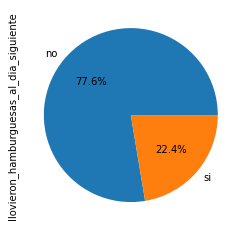

In [67]:
df['llovieron_hamburguesas_al_dia_siguiente'].value_counts().plot(kind='pie', autopct='%1.1f%%')


Para responder la pregunta, analizamos la probabilidad de que llueva dos dias consecutivos. Graficamos los porcentajes de dias que llueven, o no, hamburguesas al dia siguiente, habiendo llovido hamburguesas ese dia. 

<AxesSubplot:ylabel='llovieron_hamburguesas_al_dia_siguiente'>

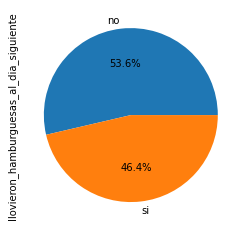

In [68]:
df[df['llovieron_hamburguesas_hoy']=='si']['llovieron_hamburguesas_al_dia_siguiente'].value_counts().plot(kind='pie', autopct='%1.1f%%')


Observamos que cuando llueve, al dia siguiente llueve también en el 46.4% de los casos.

Luego analizamos la coincidencia entre los valores de la columna 'llovieron_hamburguesas_hoy' y 'llovieron_hamburguesas_al_dia_siguiente', y observamos que es del 75%.

In [69]:
(df['llovieron_hamburguesas_hoy'] == df['llovieron_hamburguesas_al_dia_siguiente']).mean()

0.7551547978088262

Podemos concluir que hay una alta correlación entre la lluvia de hamburguesas en un dia y la lluvia de hamburguesas al dia siguiente.

## 2. ¿Como se relacionan los mm de lluvia con la lluvia de hamburguesas?

Al mirar el dataset, surge una duda: ¿la columna 'mm_lluvia_dia' hace referencia a la lluvia de hamburguesas o a la lluvia de agua? Debido a la unidad utilizada, se puede asumir que se refiere a la cantidad de agua que cae en un día, aunque es lógico pensar que esto podría estar fuertemente relacionado con la lluvia de hamburguesas.

Primero graficamos la distribución de los mm de lluvia por dia. Se espera que haya una gran cantidad de muestras con valor 0, ya que la mayoría de los días no llueve.

<AxesSubplot:ylabel='Frequency'>

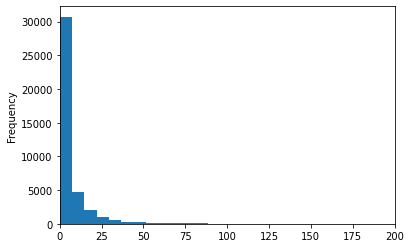

In [70]:
df[df['mm_lluvia_dia']>0]['mm_lluvia_dia'].plot(kind='hist', xlim = (0, 200), bins=50)

Observamos que, como era de esperar, en la gran mayoria de los casos la cantidad de lluvia que cae es muy baja o nula. 

Graficando un density plot entre 0 y 25, se observa que la densidad alcanza un máximo alrededor de 1 mm, y luego disminuye rápidamente.

<AxesSubplot:ylabel='Density'>

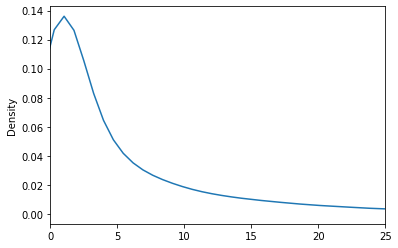

In [71]:
df[df['mm_lluvia_dia']>0]['mm_lluvia_dia'].plot(kind='density', xlim = (0, 25))

Ahora veremos si los milímetros diarios están relacionados con la lluvia de hamburguesas.

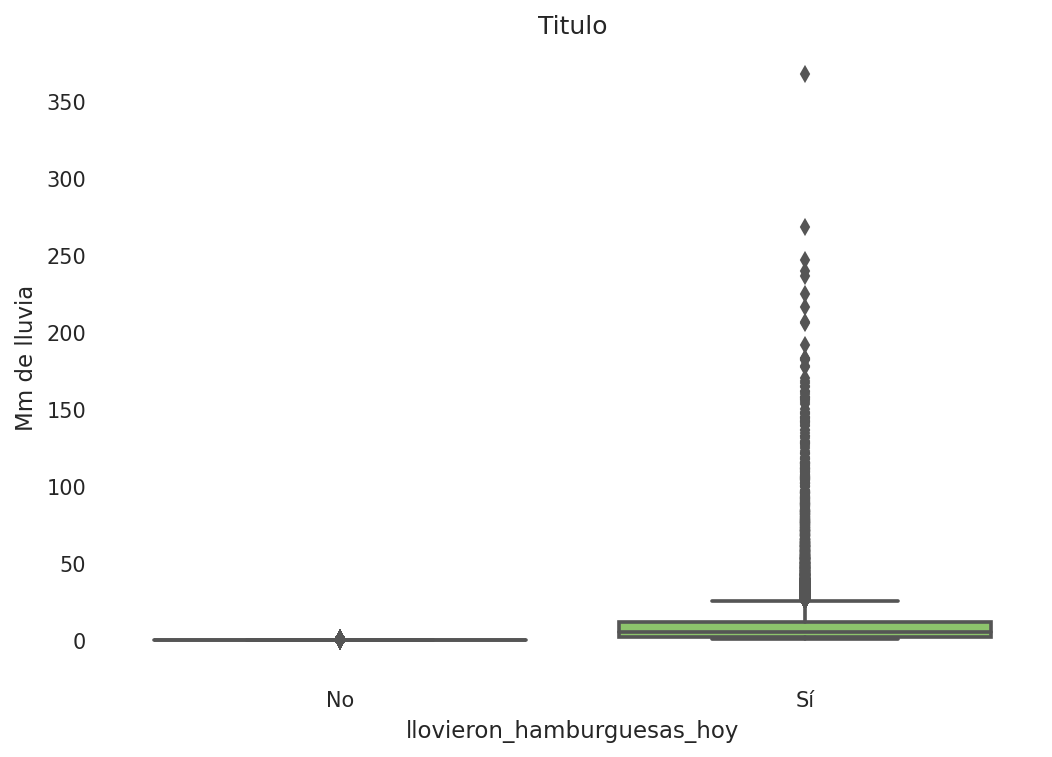

In [17]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='mm_lluvia_dia',
    x='llovieron_hamburguesas_hoy',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Mm de lluvia")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Observamos que, los días que no llovieron hamburguesas registran un valor de mm de lluvia igual a 0, exceptuando algunos outliers que poseen valores muy cercanos a 0. Por otro lado, en los días que sí llovieron hamburguesas se registraron valores siguiendo la distribución analizada anteriormente.

Por lo tanto, la lluvia de hamburguesas parece estar íntimamente ligada a los milímetros de lluvia diarios. 

Teniendo en cuenta esto, veremos si la cantidad de mm de lluvia de un día tienen alguna relación con si llueven o no hamburguesas al día siguiente. 

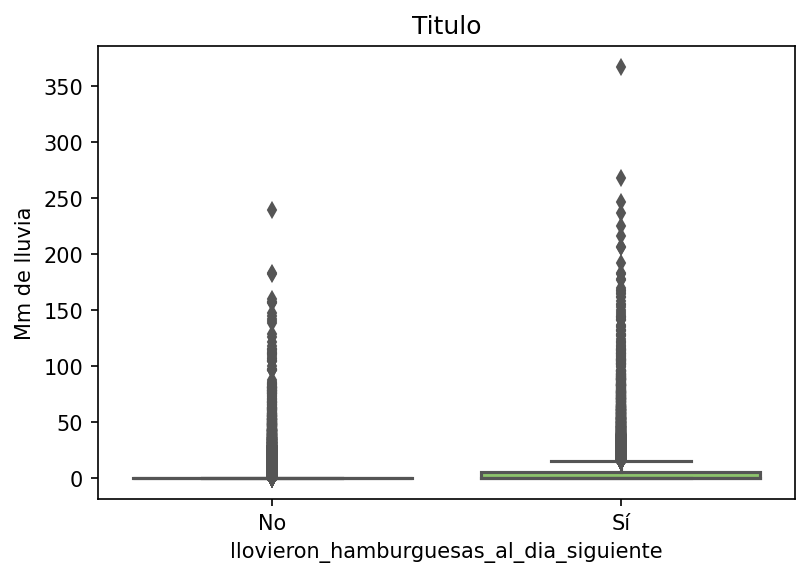

In [72]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
    y='mm_lluvia_dia',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Mm de lluvia")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

A partir del boxplot se puede inferir que en los días antes de que llovieron hamburguesas se registró una mayor cantidad de lluvia que cuando no llovieron hamburguesas.

Para cada caso, calculamos la media, con el fin de cuantificar esta relación:

In [73]:
df[['mm_lluvia_dia', 'llovieron_hamburguesas_al_dia_siguiente']].groupby('llovieron_hamburguesas_al_dia_siguiente').mean()

,mm_lluvia_dia
llovieron_hamburguesas_al_dia_siguiente,
no,1.261539
si,6.138335


Como conclusión de este análisis podemos decir que una alta cantidad de lluvia en un día puede indicar que al día siguiente van a llover hamburguesas.

## 3. ¿Como se relaciona la temperatura con la variable target?


En el dataset hay 4 columnas con datos de temperatura: máxima, mínima, tarde y temprano. En primer lugar analizaremos qué relación hay entre estos datos.

<AxesSubplot:xlabel='temp_max', ylabel='temperatura_tarde'>

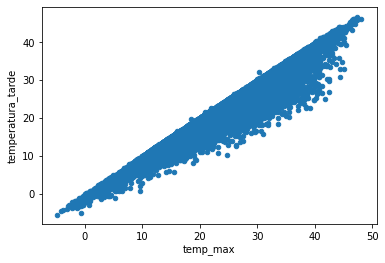

In [74]:
df.plot(
    x='temp_max',
    y='temperatura_tarde',
    kind='scatter',
)

<AxesSubplot:xlabel='temp_min', ylabel='temperatura_temprano'>

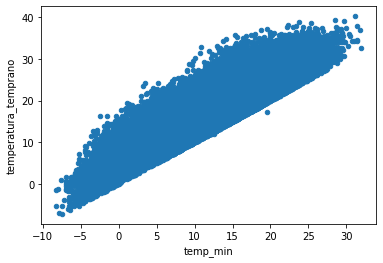

In [75]:
df.plot(
    x='temp_min',
    y='temperatura_temprano',
    kind='scatter',
)

<AxesSubplot:xlabel='temp_max', ylabel='temp_min'>

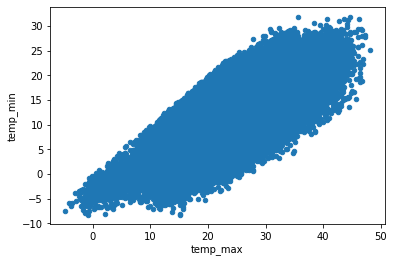

In [76]:
df.plot(x='temp_max', y='temp_min', kind='scatter')

Parece haber una correlación alta entre la temperatura máxima y la temperatura de la tarde. En los otros casos, los datos están más dispersos, con lo cual no hay una correlación tan alta como en el primer caso.

Dada la alta correlación entre temp_max y temperatura_tarde, solo analizaremos una de ellas con respecto a la variable target.

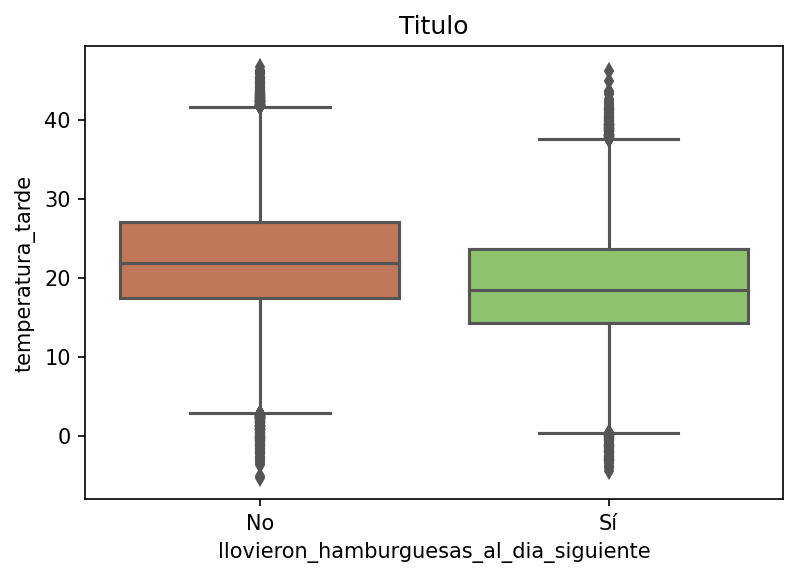

In [77]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='temperatura_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

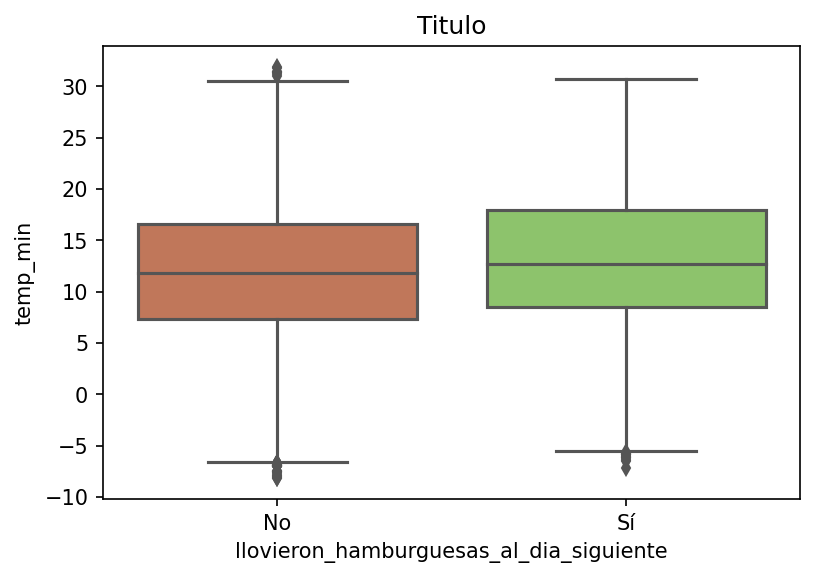

In [78]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='temp_min',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

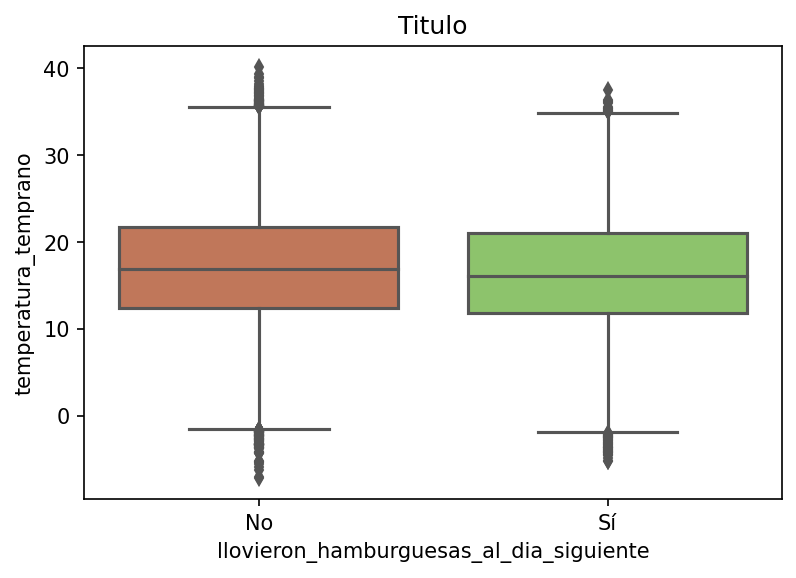

In [79]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='temperatura_temprano',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Se observa que la temperatura de la tarde es la que más varía entre los dos casos, siendo más baja en el caso en que llueven hamburguesas al día siguiente. En particular, la mediana en el caso 'si' tiene un valor muy cercano al primer cuartil del caso 'no'. 

En la temperatura temprano y la temperatura minima no se observaron diferencias significativas.

Por lo tanto, podemos concluir que hay una mayor probabilidad de lluvia de hamburguesas al día siguiente cuando las temperaturas de la tarde son bajas.

## 4. ¿Como se relaciona la humedad con la variable target?

Queremos obtener una conclusión acerca de la importancia del nivel de humedad a la hora de determinar si lloverán hamburguesas al dia siguiente. Graficamos la función de densidad de probabilidad de la variable 'humedad_tarde'.

<AxesSubplot:ylabel='Density'>

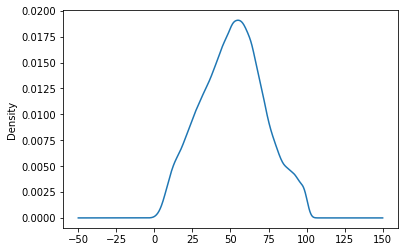

In [80]:
df['humedad_tarde'].plot(kind='density')

Podemos ver los valores medidos de humedad alcanzan su mayor densidad alrededor del 50%.
Primero revisamos su relación con la humedad a la tarde.

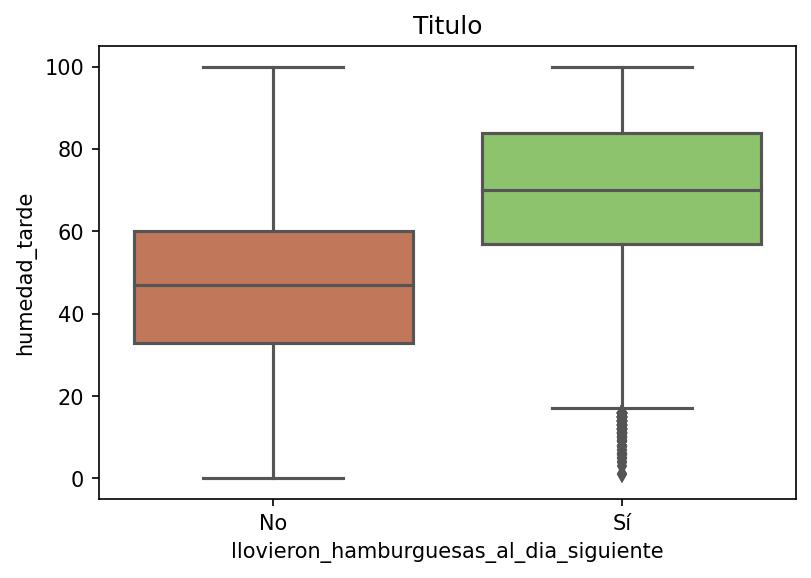

In [81]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
    y='humedad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

La humedad relativa del aire se define como el cociente entre la humedad que contiene el aire y la humedad de saturación, expresado en tanto por ciento %. Se puede observar que cuando la humedad de la tarde es mayor al 60%, se concentran mucho los valores en lo que 'llovieron_hamburguesas_al_dia_siguiente' es 'si', es decir, hay una alta probabilidad de que lluevan hamburguesas al dia siguiente.
Ahora vemos la relación entre la humedad temprana con la variable target.

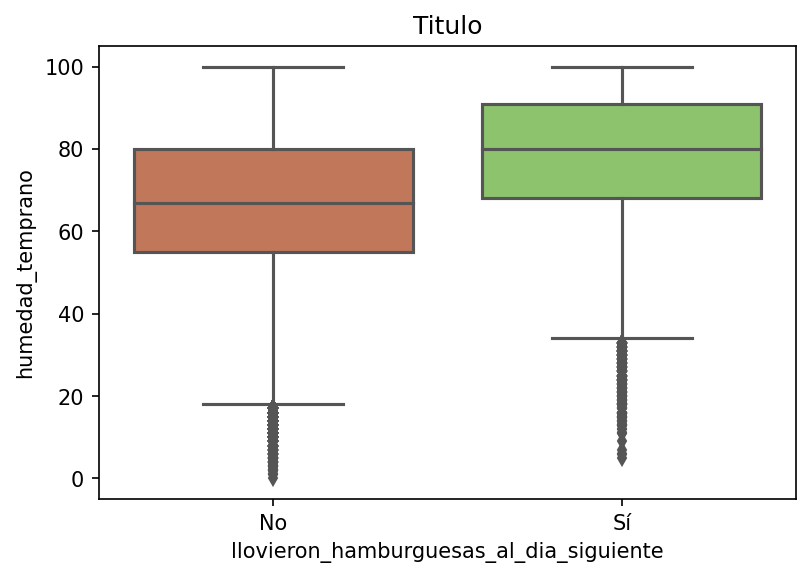

In [82]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
    y='humedad_temprano',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Se puede notar que se repite esta relación entre la alta humedad de un dia y la elevada chance de que llueva al dia siguiente, auque la diferencia no es tan marcada como en el caso anterior.

## 5. ¿Como se relaciona la nubosidad con la variable target?


La nubosidad se mide en porciones de cielo siendo cubierto por las nubes, de a octavos u "octas". Por ejemplo, si las nubes cubren la mitad del cielo se dice que la nubosidad es de 4 octas.

Graficamos su distribución utilizando un histograma.

<AxesSubplot:ylabel='Frequency'>

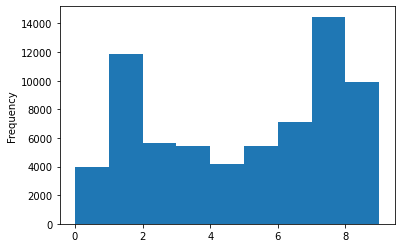

In [93]:
df['nubosidad_tarde'].plot(kind='hist', bins= 9)

<AxesSubplot:ylabel='Frequency'>

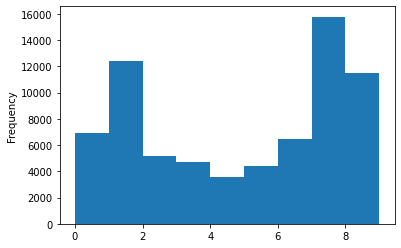

In [94]:
df['nubosidad_temprano'].plot(kind='hist', bins=9)

Vemos que la nubosidad, tanto tarde como temprano, tienen una distribución de forma irregular, con picos alrededor de 1, 7 y 8.

Dada la distribucion particular que poseen estas variables, vamos a utilizar un violin plot para visualizar como afecta la nubosidad a la lluvia de hamburguesas al dia siguiente.

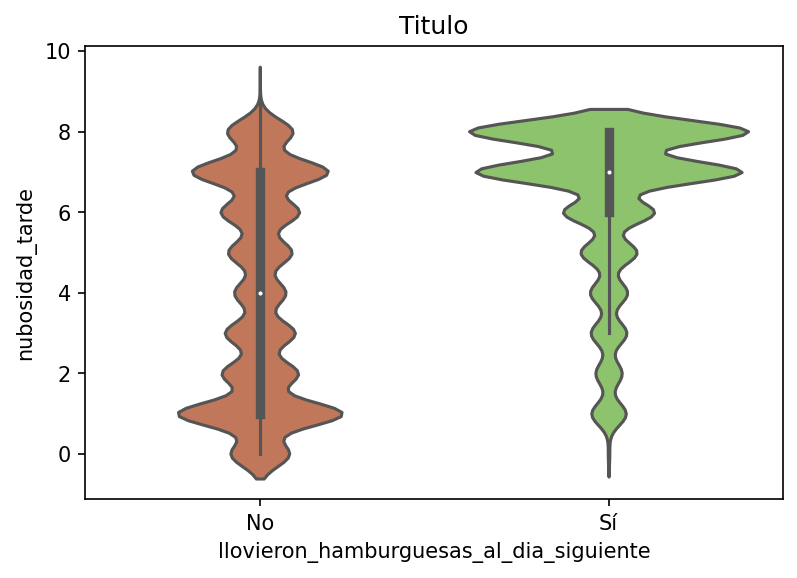

In [97]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.violinplot(
    data=df,
       
    y='nubosidad_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Podemos ver que los valores de cuando sí llueve al dia siguiente se concentran en particular cuando la nubosidad de la tarde es entre 6 y 8 octas, es decir, con nubosidades elevadas a la tarde, hay una alta probabilidad de que lluevan hamburguesas al dia siguiente. Por otro lado, los niveles de nubosidad cuando no llueven hamburguesas tienen una distribución más uniforme.

Ahora vemos la relación entre la nubosidad temprana con la variable target.

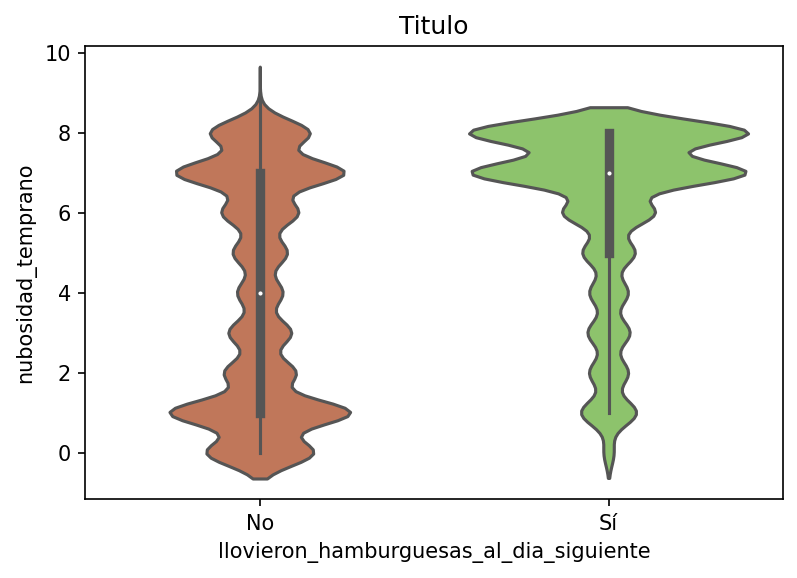

In [96]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.violinplot(
    data=df,
       
    y='nubosidad_temprano',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Observando ambos graficos, podemos notar que la mediana de la nubosidad al llover hamburguesas al dia siguiente coincide con el tercer cuartil de los casos cuando no.

Por lo tanto, concluimos que una nubosidad elevada (mayor que 7 octas) indica una mayor probabilidad de lluvia de hamburguesas al día siguiente

## 6. ¿Como se relaciona el viento con la variable target?


Nos preguntamos como afecta el comportamiento del viento en general a nuestra maquina de lluvia de hamburguesas. En el dataset hay 6 columnas con datos del viento: direccion del viento por la tarde, direccion del viento temprano, direccion de las rafagas de viento maximas, velocidad de las rafagas de viento maximas, velocidad del viento por la tarde y velocidad del viento temprano. 

En primer lugar analizaremos qué relación hay entre las distintas variables del viento.

Ahora visualizaremos las relaciones entre las distintas direcciones del viento y las veces que llueven hamburguesas al dia siguiente.

<AxesSubplot:>

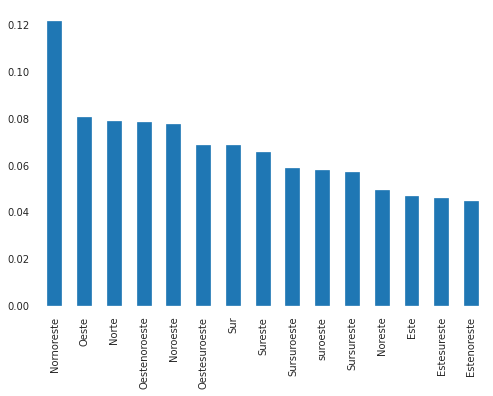

In [52]:
(df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si']['direccion_viento_tarde']).value_counts(normalize = True).sort_values(ascending=False).plot(kind='bar')

<AxesSubplot:>

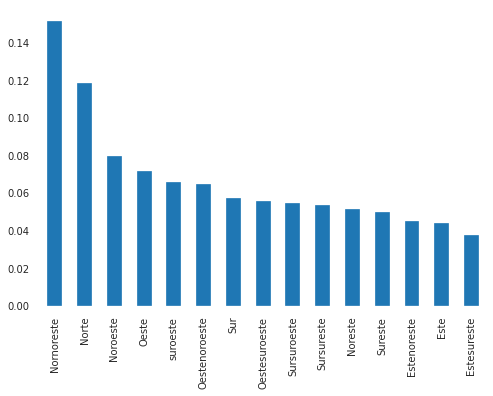

In [50]:
(df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si']['direccion_viento_temprano']).value_counts(normalize = True).sort_values(ascending=False).plot(kind='bar')

<AxesSubplot:>

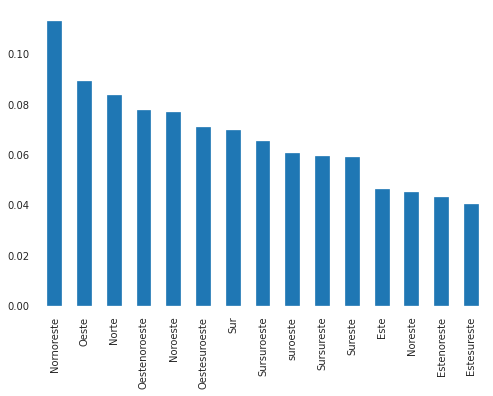

In [51]:
(df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si']['rafaga_viento_max_direccion']).value_counts(normalize = True).sort_values(ascending=False).plot(kind='bar')

Luego de visualizar los ultimos gráficos, podemos concluir que cuando la direccion del viento se concentra hacia el Nornoreste, independientemente de si es a la tarde, o temprano, aumentan las chances de que lluevan hamburguesas al dia siguiente. Aparte, en el caso de la direccion del viento temprano, se destaca la influencia sobre las lluvias cuando es hacia el Norte.
Graficamos la relacion entre las velocidades de las maximas rafagas de viento y las lluvias de hamburguesas.

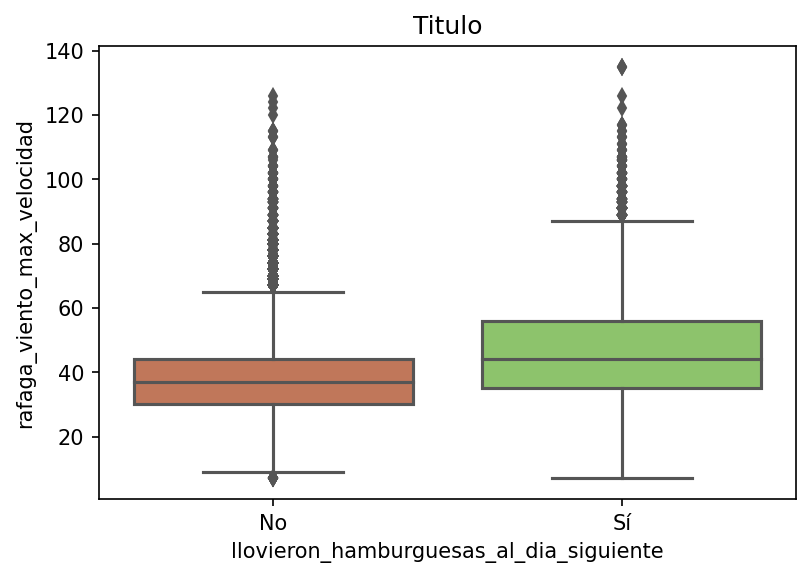

In [105]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='rafaga_viento_max_velocidad',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.xticks([False, True], ["No", "Sí"])
plt.show()

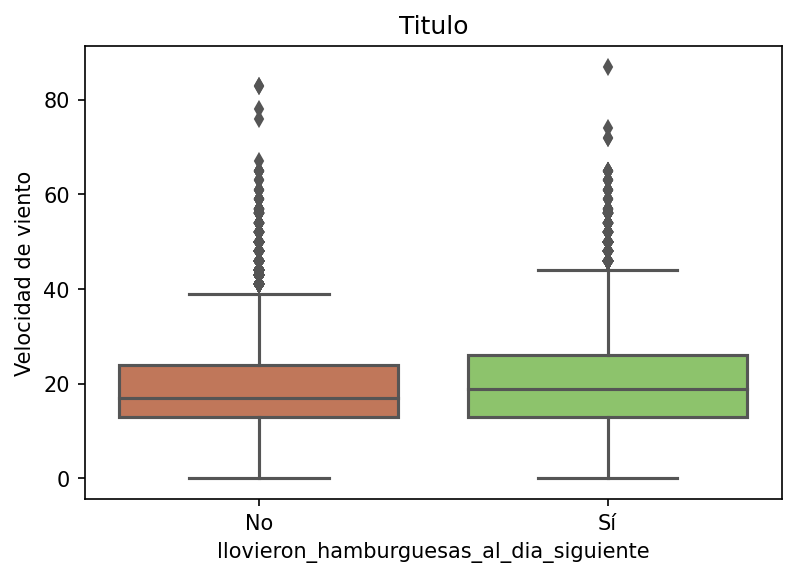

In [103]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='velocidad_viendo_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Velocidad de viento")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

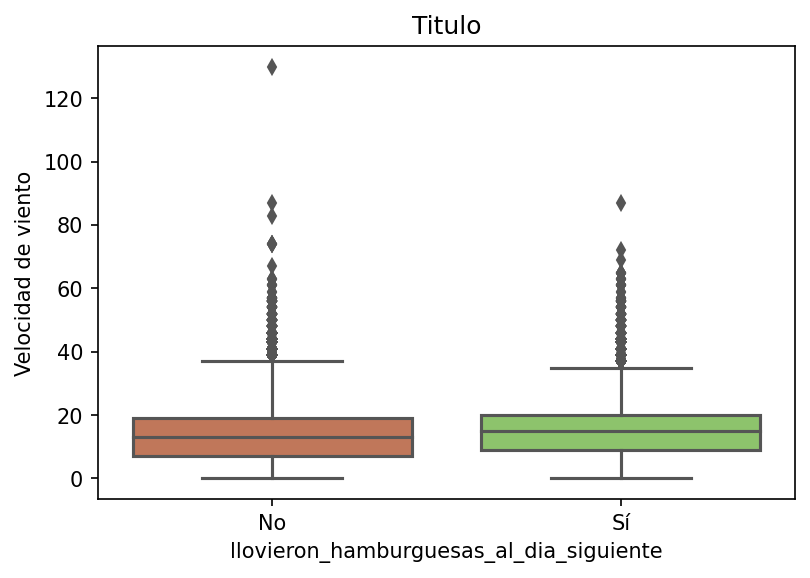

In [106]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='velocidad_viendo_temprano',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Velocidad de viento")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

Podemos notar que cuanto mayor es la velocidad de las rafagas de viento, mayor es la probabilidad de lluvia de hamburguesas, particularmente para valores mayores a 45 km/h. Aparte, nuevamente podemos ver que la mediana de los casos en los que sí llueve al dia siguiente coincide con el tercer cuartil de los casos en los que no, como con la nubosidad. 
La velocidad del viento tarde y temprano no parecen tener relación con la lluvia de hamburguesas al día siguiente.

## 7.¿Como se relaciona la presión atmosférica con la variable target?

<AxesSubplot:ylabel='Density'>

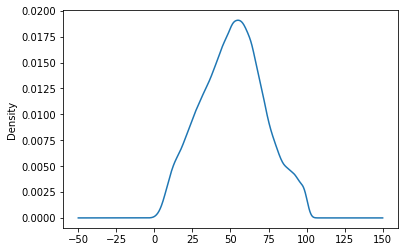

In [100]:
df['humedad_tarde'].plot(kind='density')

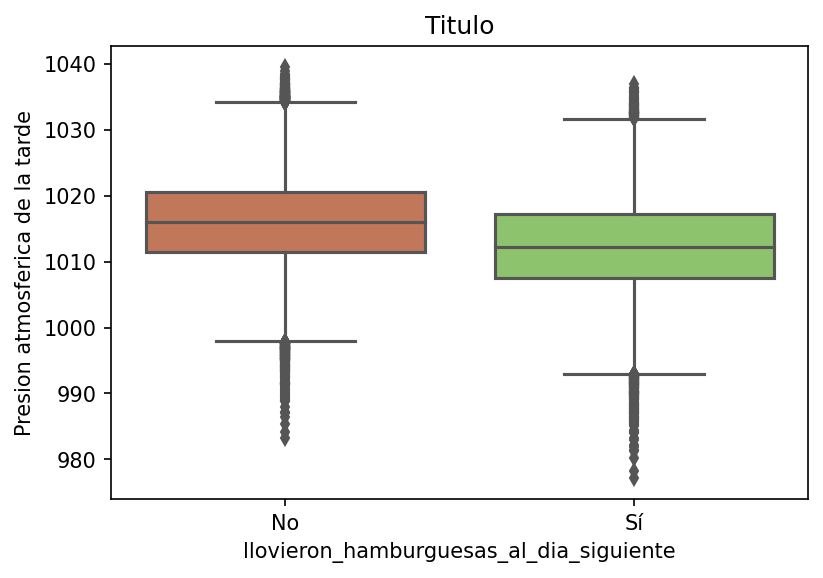

In [56]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='presion_atmosferica_tarde',
    x='llovieron_hamburguesas_al_dia_siguiente',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Presion atmosferica de la tarde")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

## 8.¿Como se relaciona los milimetros evaporados de agua con la variable target?

In [ ]:
plt.figure(dpi=150)
plt.title("Titulo")
sns.boxplot(
    data=df,
       
    y='mm_evaporados_agua',
    x='llovieron_hamburguesas_hoy',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Mm de agua evaporados")
plt.xticks([False, True], ["No", "Sí"])
plt.show()

## 9.¿Como se relaciona las horas de sol con la variable target?

In [101]:
df_no_target_mean = df_no.groupby('llovieron_hamburguesas_al_dia_siguiente').mean().transpose().drop(['id', 'presion_atmosferica_temprano'])
df_no_target_mean_normalized = df_no_target_mean.div(df_no_target_mean.sum(axis=1), axis=0)
df_no_target_mean_normalized = df_no_target_mean_normalized.sort_values(by = 'si', ascending=False)
df_no_target_mean_normalized.plot(kind='bar', stacked=True)

NameError: name 'df_no' is not defined

<AxesSubplot:>

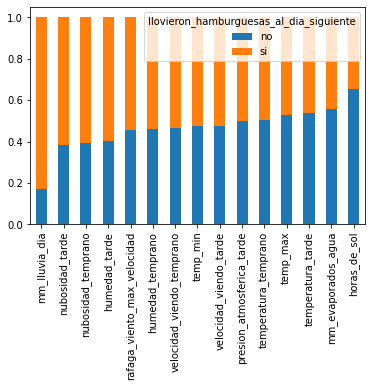

In [102]:
df_target_mean = df.groupby('llovieron_hamburguesas_al_dia_siguiente').mean().transpose().drop(['id', 'presion_atmosferica_temprano'])
df_target_mean_normalized = df_target_mean.div(df_target_mean.sum(axis=1), axis=0)
df_target_mean_normalized = df_target_mean_normalized.sort_values(by = 'si', ascending=False)
df_target_mean_normalized.plot(kind='bar', stacked=True)

## 10.¿Como varía el clima segun el barrio?

Graficamos la proporción de veces que llovieron hamburguesas en cada barrio respecto de la cantidad total de muestras tomadas por barrio. Comparamos ordenando de forma descendente.

In [ ]:
plt.rcParams["figure.dpi"] = 120
lluvia_por_barrios = df[['barrio', 'llovieron_hamburguesas_al_dia_siguiente']][df['llovieron_hamburguesas_al_dia_siguiente']=='si'].groupby('barrio').count()

lluvia_por_barrios /=  df[['barrio', 'llovieron_hamburguesas_al_dia_siguiente']].groupby('barrio').count()

lluvia_por_barrios.sort_values(by = 'llovieron_hamburguesas_al_dia_siguiente', ascending=False).plot(kind = 'bar')

plt.show()

Graficamos el promedio de horas de sol por barrio, y notamos que en varios no se tomaron datos de dicho atributo.

In [ ]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'horas_de_sol']].groupby('barrio').mean().sort_values(by = 'horas_de_sol', ascending=False).plot(kind = 'bar')

plt.show()

In [ ]:
Hacemos el mismo analisis que el anterior, pero con los atributos 'humedad_tarde' y 'humedad_temprana'.

In [ ]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'humedad_tarde']].groupby('barrio').mean().sort_values(by = 'humedad_tarde', ascending=False).plot(kind = 'bar')

plt.show()

In [ ]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'humedad_temprano']].groupby('barrio').mean().sort_values(by = 'humedad_temprano', ascending=False).plot(kind = 'bar')

plt.show()

In [ ]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'mm_evaporados_agua']].groupby('barrio').mean().sort_values(by = 'mm_evaporados_agua', ascending=False).plot(kind = 'bar')

plt.show()

In [ ]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'mm_lluvia_dia']].groupby('barrio').mean().sort_values(by = 'mm_lluvia_dia', ascending=False).plot(kind = 'bar')

plt.show()

In [ ]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'temp_min', 'temp_max']].groupby('barrio').mean().sort_values(by = 'temp_max', ascending=False).plot(kind = 'bar')

plt.show()

In [ ]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'temperatura_tarde', 'temp_max']].groupby('barrio').mean().sort_values(by = 'temperatura_tarde', ascending=False).plot(kind = 'bar')

plt.show()

In [ ]:
plt.rcParams["figure.dpi"] = 120

df[['barrio', 'temperatura_temprano', 'temp_min']].groupby('barrio').mean().sort_values(by = 'temperatura_temprano', ascending=False).plot(kind = 'bar')

plt.show()

In [ ]:
df_no_si['barrio'].value_counts().plot(kind='bar')

In [ ]:
plt.figure(figsize=(5, 9))
sns.heatmap(pd.pivot_table(df, index='barrio', columns='direccion_viento_tarde', aggfunc='size'), xticklabels=True, yticklabels=True, cmap='Wistia')

In [ ]:
pd.pivot_table(df, index='barrio', columns='llovieron_hamburguesas_al_dia_siguiente', aggfunc='size')

In [ ]:
pd.pivot_table(df, index='barrio', columns='llovieron_hamburguesas_hoy', aggfunc='size').sort_values(by='no', ascending=False)

## 11.¿Cómo varia el clima según la fecha?


In [ ]:
plt.rcParams["figure.dpi"] = 120

df[['dia', 'mm_lluvia_dia']].groupby('dia').mean().plot(kind='line')
plt.show()

In [ ]:
plt.rcParams["figure.dpi"] = 120

df[['dia', 'horas_de_sol']].groupby('dia').mean().plot(kind='line')
plt.show()

In [ ]:
((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby(df['dia'].dt.month).size())/(df.groupby(df['dia'].dt.month).size())).plot(kind='bar', xlabel='mes')


In [ ]:
df[['dia','nubosidad_tarde']].groupby(df['dia'].dt.month).mean().plot(kind='bar', xlabel='mes')

In [ ]:
df[['dia','humedad_tarde']].groupby(df['dia'].dt.month).mean().plot(kind='bar', xlabel='mes')

In [ ]:
df[['dia','temperatura_tarde']].groupby(df['dia'].dt.month).mean().plot(kind='bar', xlabel='mes')

In [ ]:
((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby(df['dia'].dt.year).size())/(df.groupby(df['dia'].dt.year).size())).plot(kind='bar', xlabel='año')


In [ ]:
mes_anio = ((df[df['llovieron_hamburguesas_al_dia_siguiente'] == 'si'].groupby([df['dia'].dt.month, df['dia'].dt.year]).size())/(df.groupby([df['dia'].dt.month, df['dia'].dt.year]).size())).rename_axis(['mes','año']).to_frame()
mes_anio.columns = ['llovieron_hamburguesas_al_dia_siguiente']
mes_anio = mes_anio.reset_index(level=[0,1])
sns.heatmap(pd.pivot_table(mes_anio, index='año', columns='mes', values='llovieron_hamburguesas_al_dia_siguiente'), cmap='Blues')
